# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [91]:
#!pip install transformers torch nltk pyLDAvis wordcloud

In [124]:
import requests
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
import pyLDAvis.sklearn
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from transformers import pipeline
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

In [40]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [41]:
df = pd.DataFrame()
df["reviews"] = reviews

In [ ]:
!mkdir data

In [46]:
df.to_csv("data/BA_reviews.csv", index=None)

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

### Data Preprocessing

In [47]:
# load the dataset
df = pd.read_csv("data/BA_reviews.csv")

In [48]:
# Split the Review column into two columns at the first occurrence of "|"
df[['Status', 'Review']] = df['reviews'].str.split('|', n=1, expand=True)

# Strip whitespace from both new columns
df['Status'] = df['Status'].str.strip()
df['Review'] = df['Review'].str.strip()

In [49]:
# dropping reviews column
df.drop('reviews', axis=1, inplace=True)

In [50]:
# Convert the Status column to categorical with binary values
# Not Verified: 0 and Verified: 1
df['Status'] = pd.Categorical(df['Status'])
df['Status'] = df['Status'].cat.codes

In [51]:
# Download stopwords and wordnet from nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [52]:
# Define function for text preprocessing
stopwords_list = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove special characters and digits
    text = re.sub('[^A-Za-z]+', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stopwords_list)
    # Lemmatize words
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    return text

In [53]:
# Apply Preprocessing function to the review text
df['Review'] = df['Review'].apply(preprocess_text)

In [54]:
# Save processed reviews
df.to_csv("data/BA_processed_reviews.csv", index=None)

### Topic Modeling

In [55]:
# Create the document-term matrix
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
doc_term_matrix = vectorizer.fit_transform(df['Review'])

In [56]:
# Create the LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=0)

In [57]:
# Display the topics
topic_keywords = []
for i, topic in enumerate(lda.components_):
    topic_keywords.append(', '.join([vectorizer.get_feature_names()[index] for index in topic.argsort()[:-6:-1]]))
    
df_topics = pd.DataFrame({'Topic_Keywords': topic_keywords})
df_topics.index.name = 'Topic_ID'
display(df_topics)

,Topic_Keywords
Topic_ID,
0,"seat, flight, good, crew, service"
1,"flight, service, ba, london, staff"
2,"flight, ba, food, seat, london"
3,"ba, seat, airline, flight, service"
4,"flight, ba, hour, london, day"


In [71]:
# Visualize the topics
vis = pyLDAvis.sklearn.prepare(lda, doc_term_matrix, vectorizer, sort_topics=False)
pyLDAvis.display(vis)

In [72]:
# Save the visualization as an HTML file
pyLDAvis.save_html(vis, 'lda_visualization.html')

In [88]:
# Save processed reviews
df.to_csv("data/BA_processed_reviews.csv", index=None)

### Sentiment Analysis using HuggingFace

In [81]:
# Load and preprocess the dataset
df = pd.read_csv('data/BA_processed_reviews.csv')
df = df[['Review']]
df = df.dropna()

In [82]:
# Define the sentiment analysis pipeline using a pre-trained model
classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [83]:
# Apply the sentiment analysis pipeline to the reviews
sentiment_scores = classifier(df['Review'].tolist())

In [84]:
# Add the sentiment scores to the original dataframe
df['Sentiment'] = [score['label'] for score in sentiment_scores]
df['Sentiment Score'] = [score['score'] for score in sentiment_scores]

In [85]:
# Save processed reviews
df.to_csv("data/BA_processed_reviews.csv", index=None)

### Sentiment Word Clouds

In [86]:
# filter out the reviews with positive and negative sentiments
positive_reviews = df[df['Sentiment'] == 'POSITIVE']['Review']
negative_reviews = df[df['Sentiment'] == 'NEGATIVE']['Review']

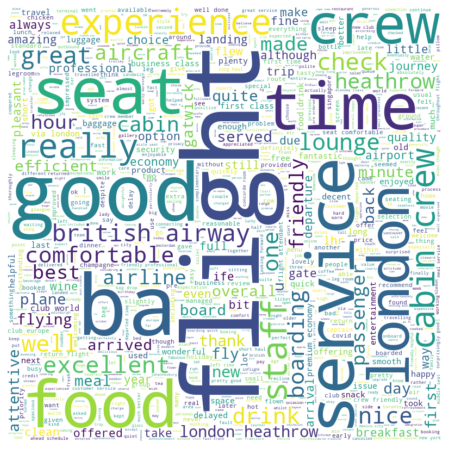

In [87]:
# create a word cloud for positive reviews
positive_text = ' '.join(positive_reviews)
positive_wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=1000).generate(positive_text)

# plot the word clouds
plt.figure(figsize=(8,8))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

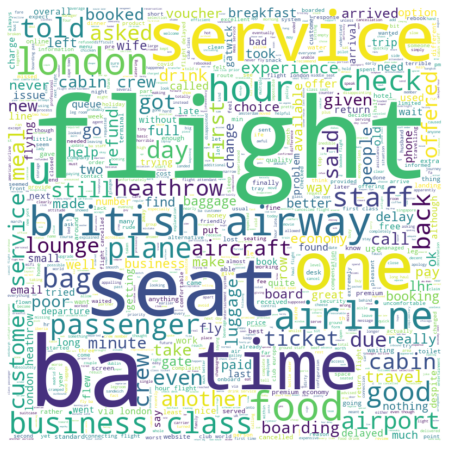

In [88]:
# create a word cloud for negative reviews
negative_text = ' '.join(negative_reviews)
negative_wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=1000).generate(negative_text)

plt.figure(figsize=(8,8))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [100]:
# Load and preprocess the dataset
df = pd.read_csv('data/BA_processed_reviews.csv')

In [101]:
df.head()

,Review,Sentiment,Sentiment Score
0,copenhagen chaotic ticket counter assignment h...,NEGATIVE,0.994656
1,worst experience life trying deal customer ser...,NEGATIVE,0.999673
2,due code sharing cathay pacific downgraded ba ...,NEGATIVE,0.998187
3,lhr check quick first wing quickly security fi...,NEGATIVE,0.997017
4,recommend british airway tried call customer s...,NEGATIVE,0.998496


### Customer Segmentation

Cluster 0 (140 customers):
Top keywords: booking, ticket, day, customer, booked, ba, voucher, refund, cancelled, flight
--------------------------------------------------
Cluster 1 (200 customers):
Top keywords: row, service, premium, food, flight, ba, economy, business, class, seat
--------------------------------------------------
Cluster 2 (357 customers):
Top keywords: customer, british, airway, service, london, hour, bag, staff, ba, flight
--------------------------------------------------
Cluster 3 (303 customers):
Top keywords: club, seat, service, time, ba, cabin, food, crew, good, flight
--------------------------------------------------


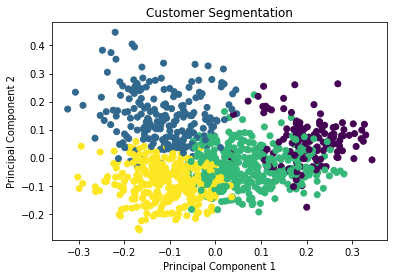

In [121]:
warnings.filterwarnings("ignore")

# Load and preprocess the dataset
df = pd.read_csv('data/BA_processed_reviews.csv')
df = df[['Review']]

# Extract features from the dataset using TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['Review'])

# Cluster the customers using KMeans
num_clusters = 4  # set the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Add cluster labels to the dataset
df['Cluster'] = kmeans.labels_

# Analyze the clusters
for cluster in range(num_clusters):
    print(f'Cluster {cluster} ({sum(df["Cluster"]==cluster)} customers):')
    top_keywords = np.array(vectorizer.get_feature_names())[np.argsort(kmeans.cluster_centers_[cluster])[-10:]]
    print(f'Top keywords: {", ".join(top_keywords)}')
    print('-' * 50)

# Visualize the clusters using PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('Customer Segmentation')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
